# Prompt

## Try-it 9.2: Predicting Wages

This activity is meant to summarize your work with regularized regression models.  You will use your earlier work with data preparation and pipelines together with what you've learned with grid searches to determine an optimal model.  In addition to the prior strategies, this example is an excellent opportunity to utilize the `TransformedTargetRegressor` estimator in scikitlearn.

## The Data

This dataset is loaded from the openml resource library.  Originally from census data, the data contains wage and demographic information on 534 individuals.  

From the dataset documentation [here](https://www.openml.org/d/534):

> The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership.

## Task

Build regression models to predict `WAGE`.  Incorporate the categorical features and transform the target using a logarithm.  Build `Ridge` models and consider some different amounts of regularization.  

After fitting your model, interpret the model and try to understand what features led to higher wages.  Consider using `permutation_importance` that you encountered in module 8.  Discuss your findings in the class forum.

For an in depth example discussing the perils of interpreting the coefficients see the example in scikitlearn examples [here](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html).

# Imports

In [1]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import (
    make_column_transformer,
    TransformedTargetRegressor,
    make_column_selector,
)
from sklearn.utils import Bunch
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error

from IPython.display import Image

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

In [3]:
df = fetch_openml(data_id=534, as_frame=True).frame

In [4]:
df = df.query("WAGE > 1 and WAGE < 30")  # snip 2 outliers

In [5]:
df.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


# Feature Naming

In [6]:
target_feature = "WAGE"
numeric_features = df.columns[df.dtypes != "category"].to_list()
numeric_features.remove(target_feature)
one_hot_features = df.columns[df.dtypes == "category"].to_list()
display([numeric_features, one_hot_features])

[['EDUCATION', 'EXPERIENCE', 'AGE'],
 ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR']]

In [7]:
numeric_features_prefix = ["numeric_" + name for name in numeric_features]
one_hot_features_prefix = ["category_" + name for name in one_hot_features]
df = df.rename(columns=dict(zip(one_hot_features, one_hot_features_prefix))).rename(
    columns=dict(zip(numeric_features, numeric_features_prefix))
)

numeric_features = numeric_features_prefix
one_hot_features = one_hot_features_prefix

# Assign to Feature and Target Frames

In [8]:
X = df.drop(columns=target_feature)
y = df[target_feature]

# Develop Processing Pipeline

## Polynomial Features

In [9]:
poly_pipe = Pipeline(
    [
        (
            "scaler",
            make_column_transformer(
                (
                    StandardScaler(),
                    numeric_features,
                ),
            ),
        ),
        ("poly", PolynomialFeatures(include_bias=False)),
    ]
).fit(X)

display(poly_pipe)

Pipeline(steps=[('scaler',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['numeric_EDUCATION',
                                                   'numeric_EXPERIENCE',
                                                   'numeric_AGE'])])),
                ('poly', PolynomialFeatures(include_bias=False))])

In [10]:
# pd.DataFrame(
#     poly_pipe.transform(X), columns=poly_pipe.get_feature_names_out()
# )

## One Hot Features

In [11]:
ohe_pipe = Pipeline(
    [
        (
            "ohe",
            make_column_transformer(
                (
                    OneHotEncoder(drop="if_binary"),
                    one_hot_features,
                ),
            ),
        ),
    ]
).fit(X)

display(ohe_pipe)

Pipeline(steps=[('ohe',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['category_SOUTH',
                                                   'category_SEX',
                                                   'category_UNION',
                                                   'category_RACE',
                                                   'category_OCCUPATION',
                                                   'category_SECTOR',
                                                   'category_MARR'])]))])

In [12]:
# pd.DataFrame(ohe_pipe.transform(X), columns=ohe_pipe.get_feature_names_out())

## Union of Features

In [13]:
feature_union = FeatureUnion(
    [
        ("poly_pipe", poly_pipe),
        ("ohe_pipe", ohe_pipe),
    ]
).fit(X)

display(feature_union)

FeatureUnion(transformer_list=[('poly_pipe',
                                Pipeline(steps=[('scaler',
                                                 ColumnTransformer(transformers=[('standardscaler',
                                                                                  StandardScaler(),
                                                                                  ['numeric_EDUCATION',
                                                                                   'numeric_EXPERIENCE',
                                                                                   'numeric_AGE'])])),
                                                ('poly',
                                                 PolynomialFeatures(include_bias=False))])),
                               ('ohe_pipe',
                                Pipeline(steps=[('ohe',
                                                 ColumnTransformer(transformers=[('onehotencoder',
                                                                                  OneHotEncoder(drop='if_binary'),
                                                                                  ['category_SOUTH',
                                                                                   'category_SEX',
                                                                                   'category_UNION',
                                                                                   'category_RACE',
                                                                                   'category_OCCUPATION',
                                                                                   'category_SECTOR',
                                                                                   'category_MARR'])]))]))])

In [14]:
# pd.DataFrame(
#     feature_union.transform(X), columns=feature_union.get_feature_names_out()
# )

## Ridge Pipeline

In [15]:
ridge_pipe = Pipeline(
    [
        ("feature_union", feature_union),
        ("scaler", StandardScaler()),
        ("ridge", Ridge(fit_intercept=True)),
    ]
)

display(ridge_pipe)

Pipeline(steps=[('feature_union',
                 FeatureUnion(transformer_list=[('poly_pipe',
                                                 Pipeline(steps=[('scaler',
                                                                  ColumnTransformer(transformers=[('standardscaler',
                                                                                                   StandardScaler(),
                                                                                                   ['numeric_EDUCATION',
                                                                                                    'numeric_EXPERIENCE',
                                                                                                    'numeric_AGE'])])),
                                                                 ('poly',
                                                                  PolynomialFeatures(include_bias=False))])),
                                                ('ohe_pipe',
                                                 Pipeline(steps=[('ohe',
                                                                  ColumnTransformer(transformers=[('onehotencoder',
                                                                                                   OneHotEncoder(drop='if_binary'),
                                                                                                   ['category_SOUTH',
                                                                                                    'category_SEX',
                                                                                                    'category_UNION',
                                                                                                    'category_RACE',
                                                                                                    'category_OCCUPATION',
                                                                                                    'category_SECTOR',
                                                                                                    'category_MARR'])]))]))])),
                ('scaler', StandardScaler()), ('ridge', Ridge())])

## Transformed Target Regression

In [16]:
ttr_pipe = Pipeline(
    [
        (
            "ttr",
            TransformedTargetRegressor(
                regressor=ridge_pipe, func=np.log, inverse_func=np.exp
            ),
        )
    ]
).fit(X, y)

ttr_pipe

Pipeline(steps=[('ttr',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Pipeline(steps=[('feature_union',
                                                                       FeatureUnion(transformer_list=[('poly_pipe',
                                                                                                       Pipeline(steps=[('scaler',
                                                                                                                        ColumnTransformer(transformers=[('standardscaler',
                                                                                                                                                         StandardScaler(),
                                                                                                                                                         ['numeric_EDUCATION',
                                                                                                                                                          'numeric_EXPERIENCE',
                                                                                                                                                          'numeric_AGE'])])),
                                                                                                                       ('poly',
                                                                                                                        PolynomialFeatures(include_bias=False))])),
                                                                                                      ('ohe_pipe',
                                                                                                       Pipeline(steps=[('ohe',
                                                                                                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                                                                                                         OneHotEncoder(drop='if_binary'),
                                                                                                                                                         ['category_SOUTH',
                                                                                                                                                          'category_SEX',
                                                                                                                                                          'category_UNION',
                                                                                                                                                          'category_RACE',
                                                                                                                                                          'category_OCCUPATION',
                                                                                                                                                          'category_SECTOR',
                                                                                                                                                          'category_MARR'])]))]))])),
                                                                      ('scaler',
                                                                       StandardScaler()),
                                                                      ('ridge',
                                                                       Ridge())])))])

# Grid Search over Hyperparameters

In [17]:
(train_inds, dev_inds) = train_test_split(
    range(len(df)), random_state=42, train_size=0.75
)

In [18]:
degree_list = range(1, 4)
alpha_list = 10 ** np.linspace(-5, 5, 51)
param_grid = {
    "ttr__regressor__feature_union__poly_pipe__poly__degree": degree_list,
    "ttr__regressor__ridge__alpha": alpha_list,
}

grid_search = GridSearchCV(
    estimator=ttr_pipe,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=[[train_inds, dev_inds]],
).fit(X, y)

In [19]:
grid_search.best_params_

{'ttr__regressor__feature_union__poly_pipe__poly__degree': 3,
 'ttr__regressor__ridge__alpha': 158.48931924611142}

In [20]:
ttr_pipe_best = grid_search.best_estimator_.fit(X, y)
ttr_pipe_best

Pipeline(steps=[('ttr',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Pipeline(steps=[('feature_union',
                                                                       FeatureUnion(transformer_list=[('poly_pipe',
                                                                                                       Pipeline(steps=[('scaler',
                                                                                                                        ColumnTransformer(transformers=[('standardscaler',
                                                                                                                                                         StandardScaler(),
                                                                                                                                                         ['numeric_EDUCATION',
                                                                                                                                                          'numeric_EXPERIENCE',
                                                                                                                                                          'numeric_AGE'])])),
                                                                                                                       ('poly',
                                                                                                                        Polynom...3,
                                                                                                                                           include_bias=False))])),
                                                                                                      ('ohe_pipe',
                                                                                                       Pipeline(steps=[('ohe',
                                                                                                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                                                                                                         OneHotEncoder(drop='if_binary'),
                                                                                                                                                         ['category_SOUTH',
                                                                                                                                                          'category_SEX',
                                                                                                                                                          'category_UNION',
                                                                                                                                                          'category_RACE',
                                                                                                                                                          'category_OCCUPATION',
                                                                                                                                                          'category_SECTOR',
                                                                                                                                                          'category_MARR'])]))]))])),
                                                                      ('scaler',
                                                                       StandardScaler()),
                                                                      ('ridge',
                                                                       Ridge(alpha=158.48931924611142))])))])

# Plot of Model Error vs. Parameters

In [21]:
results_df = pd.DataFrame(grid_search.cv_results_["params"]).join(
    pd.DataFrame({"mean_test_score": grid_search.cv_results_["mean_test_score"]})
)

results_df.columns = [name.split("__")[-1] for name in results_df.columns]
results_df

,degree,alpha,mean_test_score
0,1,0.000010,-21.064891
1,1,0.000016,-21.064889
2,1,0.000025,-21.064886
3,1,0.000040,-21.064880
4,1,0.000063,-21.064872
...,...,...,...
148,3,15848.931925,-24.634460
149,3,25118.864315,-24.852946
150,3,39810.717055,-24.999762
151,3,63095.734448,-25.096347


In [22]:
best_poly_degree = grid_search.best_params_[list(grid_search.best_params_.keys())[0]]
best_alpha = grid_search.best_params_[list(grid_search.best_params_.keys())[1]]

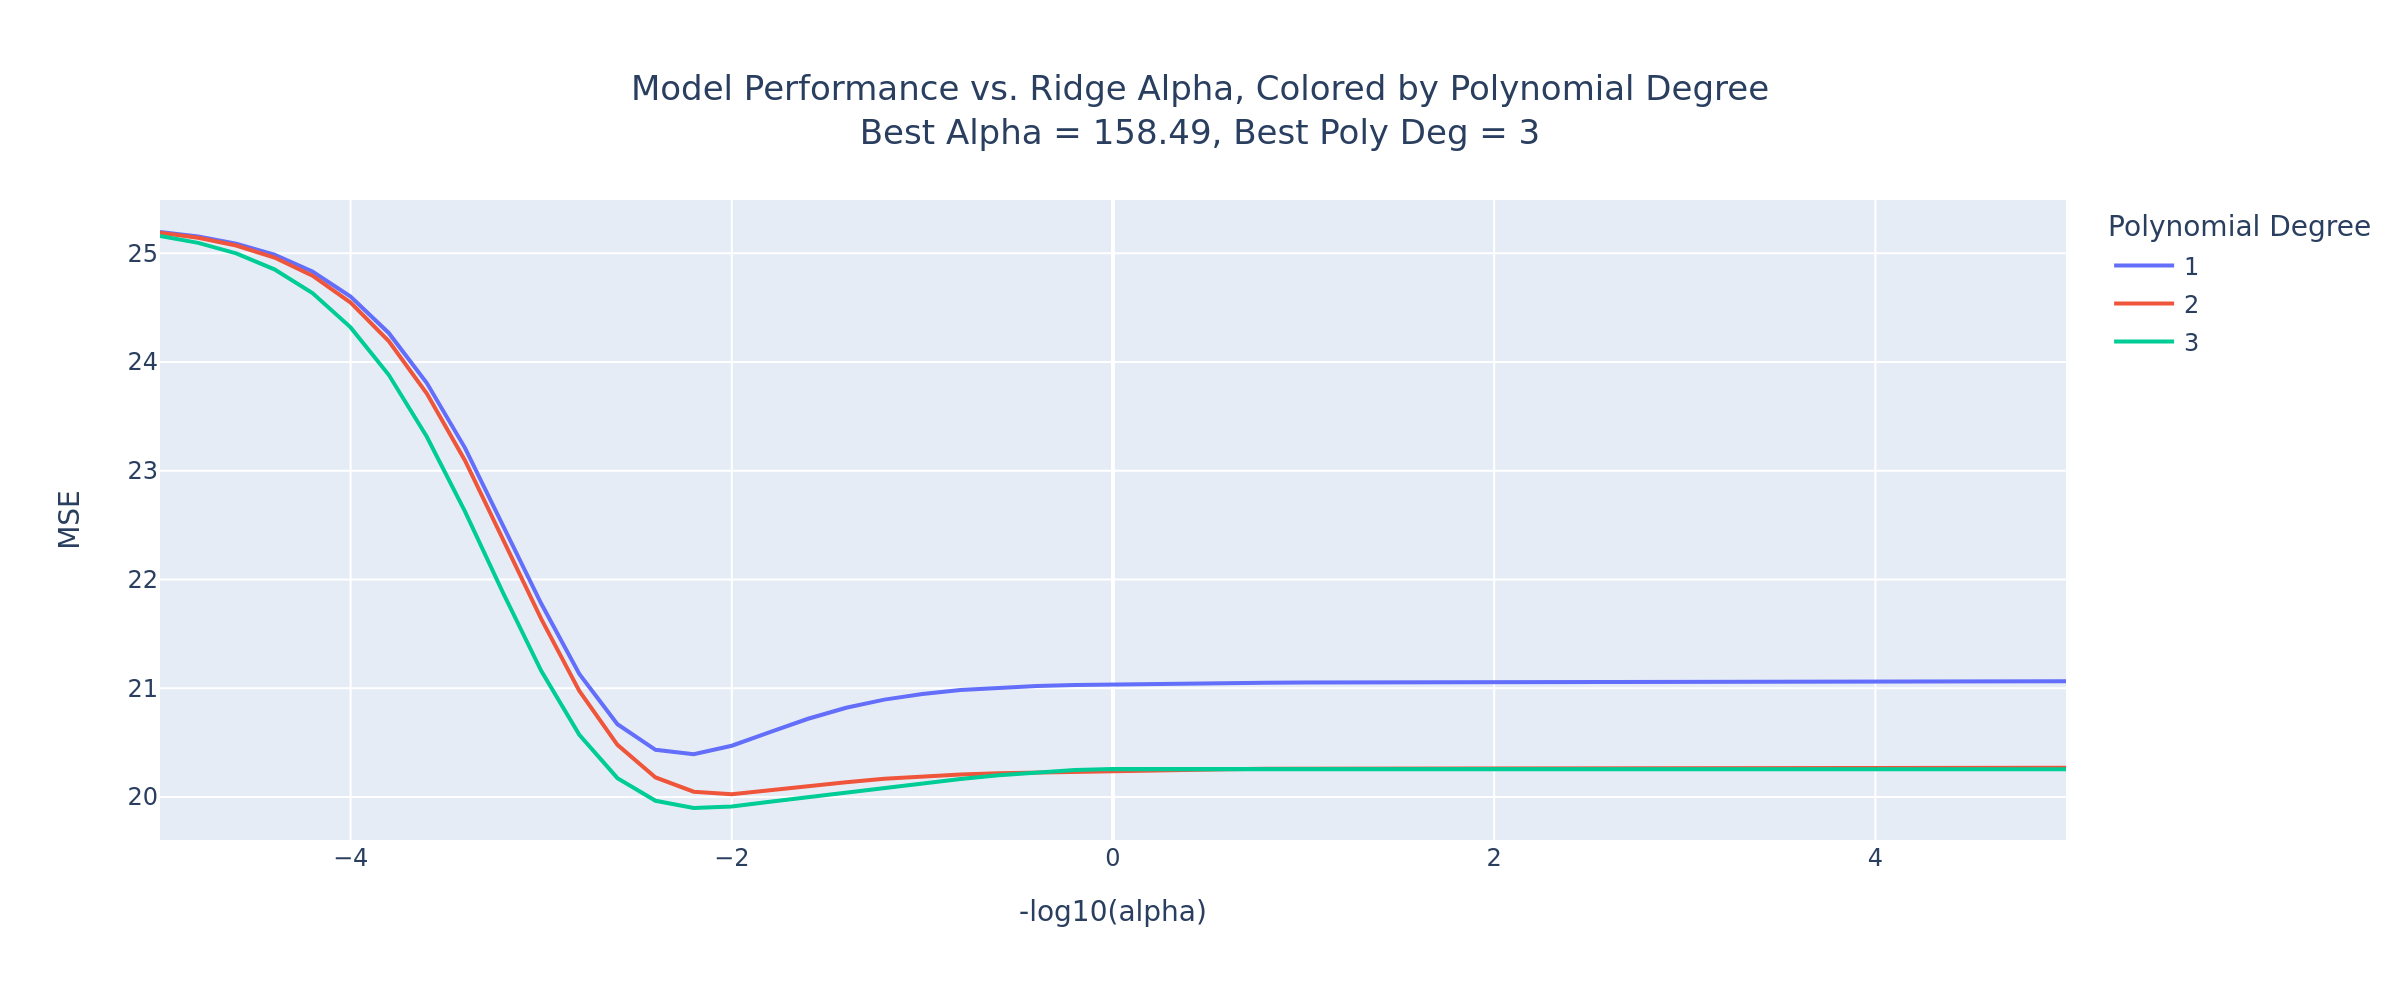

In [23]:
fig = px.line(
    results_df,
    x=-np.log10(results_df["alpha"]),
    y=-results_df["mean_test_score"],
    labels={
        "x": "-log10(alpha)",
        "y": "MSE",
        "degree": "Polynomial Degree",
    },
    title="Model Performance vs. Ridge Alpha, Colored by Polynomial Degree<br>Best Alpha = %.2f, Best Poly Deg = %d"
    % (best_alpha, best_poly_degree),
    color="degree",
)

Image(fig.update_layout(title_x=0.5).to_image(format="png", width=1200, scale=2))

# Scatter Plot of Predicted vs. Truth Data

In [24]:
y_pred = ttr_pipe.predict(X)
y_pred_best = ttr_pipe_best.predict(X)

In [25]:
mse_basic = mean_squared_error(y, y_pred)  # was - 18.416299035907095
mse_best = mean_squared_error(ttr_pipe_best.predict(X), y)
[mse_basic, mse_best]

[15.48404424796466, 15.740574797249632]

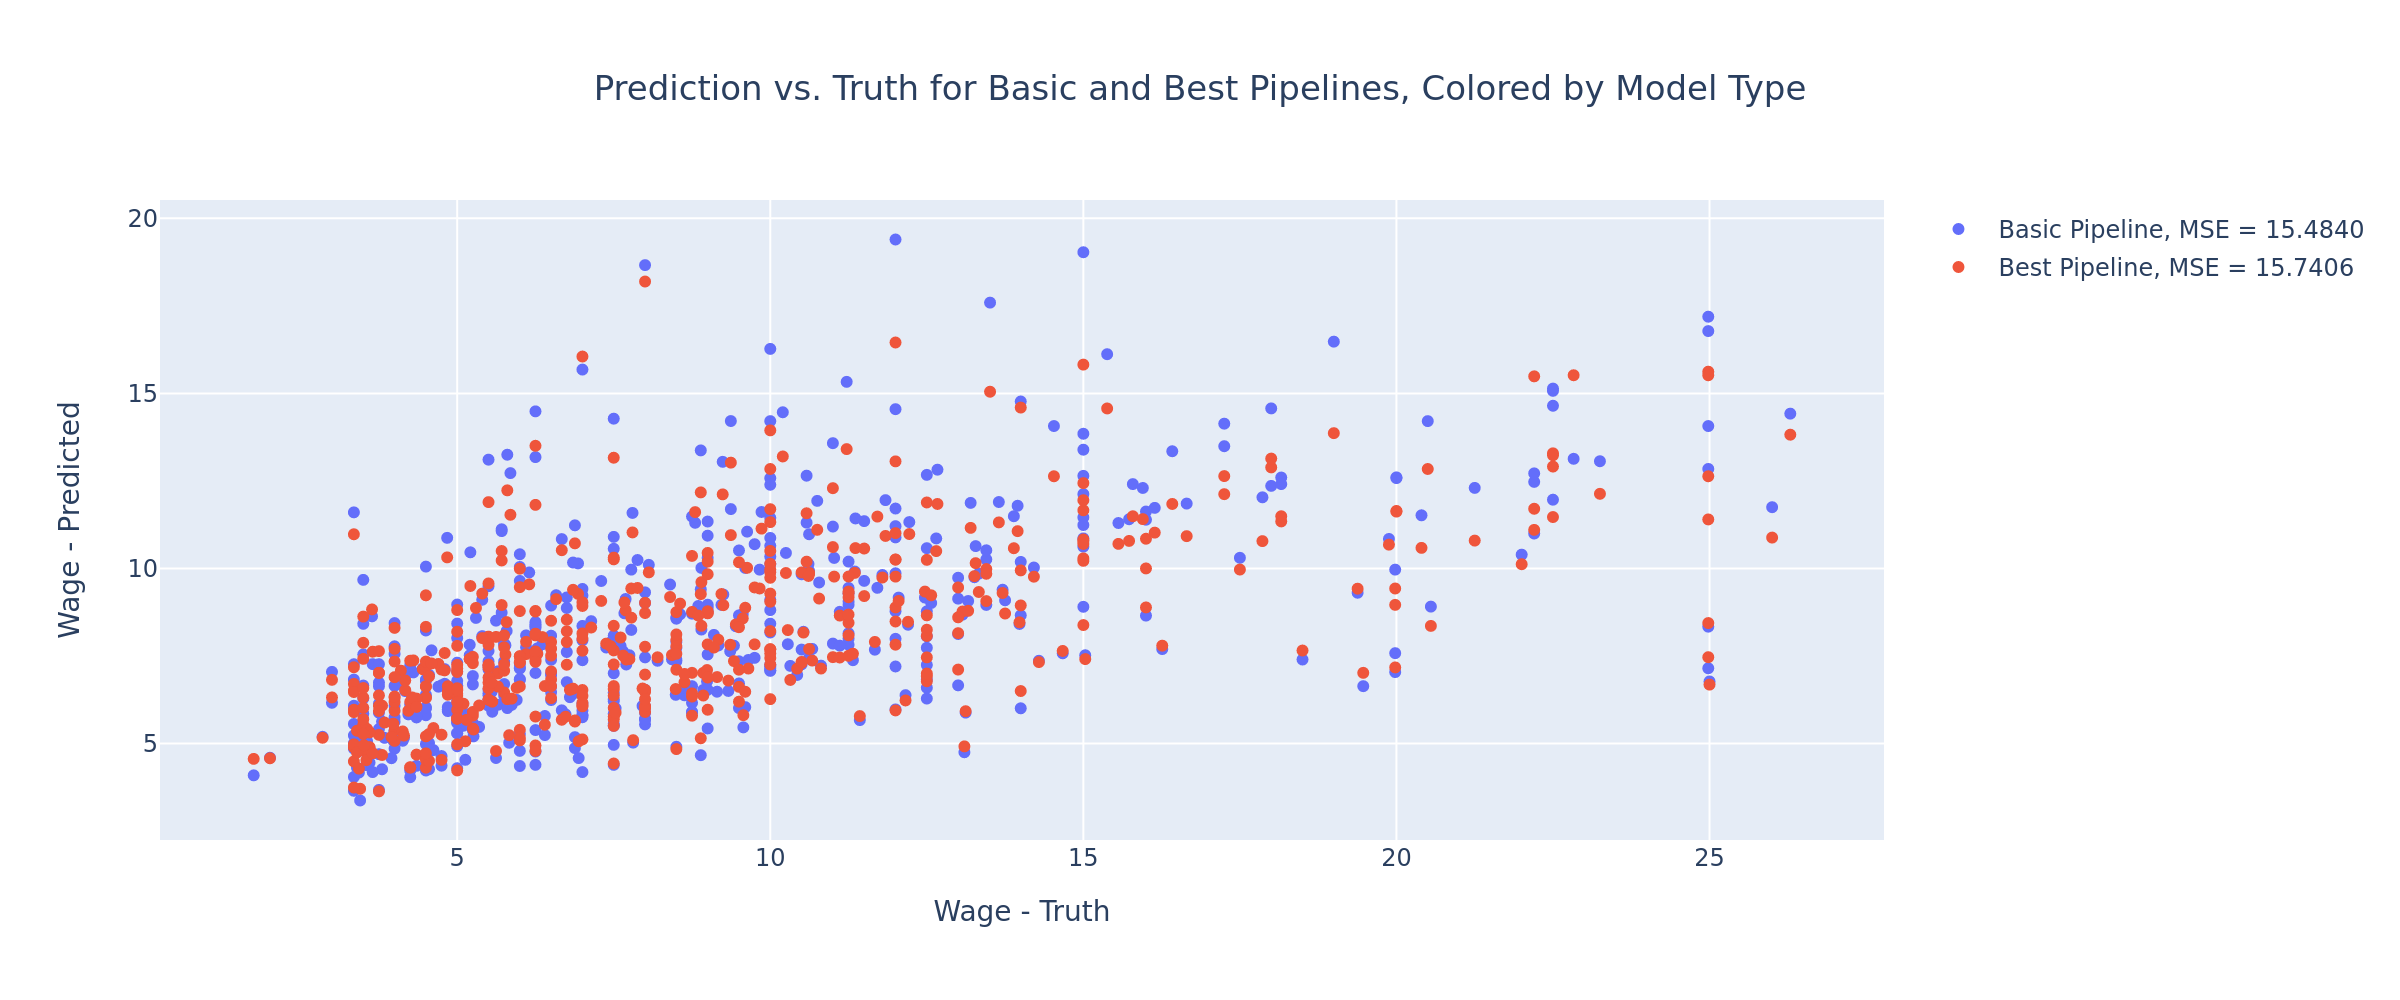

In [26]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=y,
        y=y_pred,
        mode="markers",
        name="Basic Pipeline, MSE = %.4f" % mse_basic,
    )
)

fig.add_trace(
    go.Scatter(
        x=y,
        y=y_pred_best,
        mode="markers",
        name="Best Pipeline, MSE = %.4f" % mse_best,
    )
)

fig.update_layout(
    title="Prediction vs. Truth for Basic and Best Pipelines, Colored by Model Type",
    xaxis_title="Wage - Truth",
    yaxis_title="Wage - Predicted",
)

Image(fig.update_layout(title_x=0.5).to_image(format="png", width=1200, scale=2))

# Permutation Importance

In [27]:
def make_permutation_importance_DataFrame(
    model,
    X: pd.DataFrame,
    y: pd.Series,
    permutation_importance_kwargs,
) -> pd.DataFrame:
    # Compute the importances
    pi = permutation_importance(
        model,
        X,
        y,
        **permutation_importance_kwargs,
    )

    # Get a sorting by the mean importance, then build a frame with all the importances
    # where columns sorted from most important on down
    ordered_features = list(np.array(X.columns)[np.argsort(pi.importances_mean)])[::-1]
    return pd.DataFrame(pi.importances.T, columns=X.columns)[ordered_features]

In [28]:
# Importance per feature
df_pi = make_permutation_importance_DataFrame(
    ttr_pipe_best,
    X,
    y,
    {"random_state": 42, "n_repeats": 500},
)

df_pi.head()

,numeric_EDUCATION,category_OCCUPATION,category_SEX,numeric_AGE,category_UNION,numeric_EXPERIENCE,category_SECTOR,category_RACE,category_SOUTH,category_MARR
0,0.138356,0.104885,0.050747,0.044666,0.024830,0.012199,0.016776,0.009831,0.011680,-0.000404
1,0.141890,0.103046,0.078976,0.058988,0.031346,0.019870,0.025286,0.009335,0.007828,0.004758
2,0.127667,0.114114,0.084515,0.027642,0.015565,0.004856,0.011203,0.001824,0.003894,0.004029
3,0.130200,0.122683,0.064387,0.041285,0.009345,0.013659,0.009620,0.011654,0.007407,0.002639
4,0.142152,0.124425,0.075540,0.039957,0.027561,0.008763,0.001027,0.010657,0.007343,0.004703


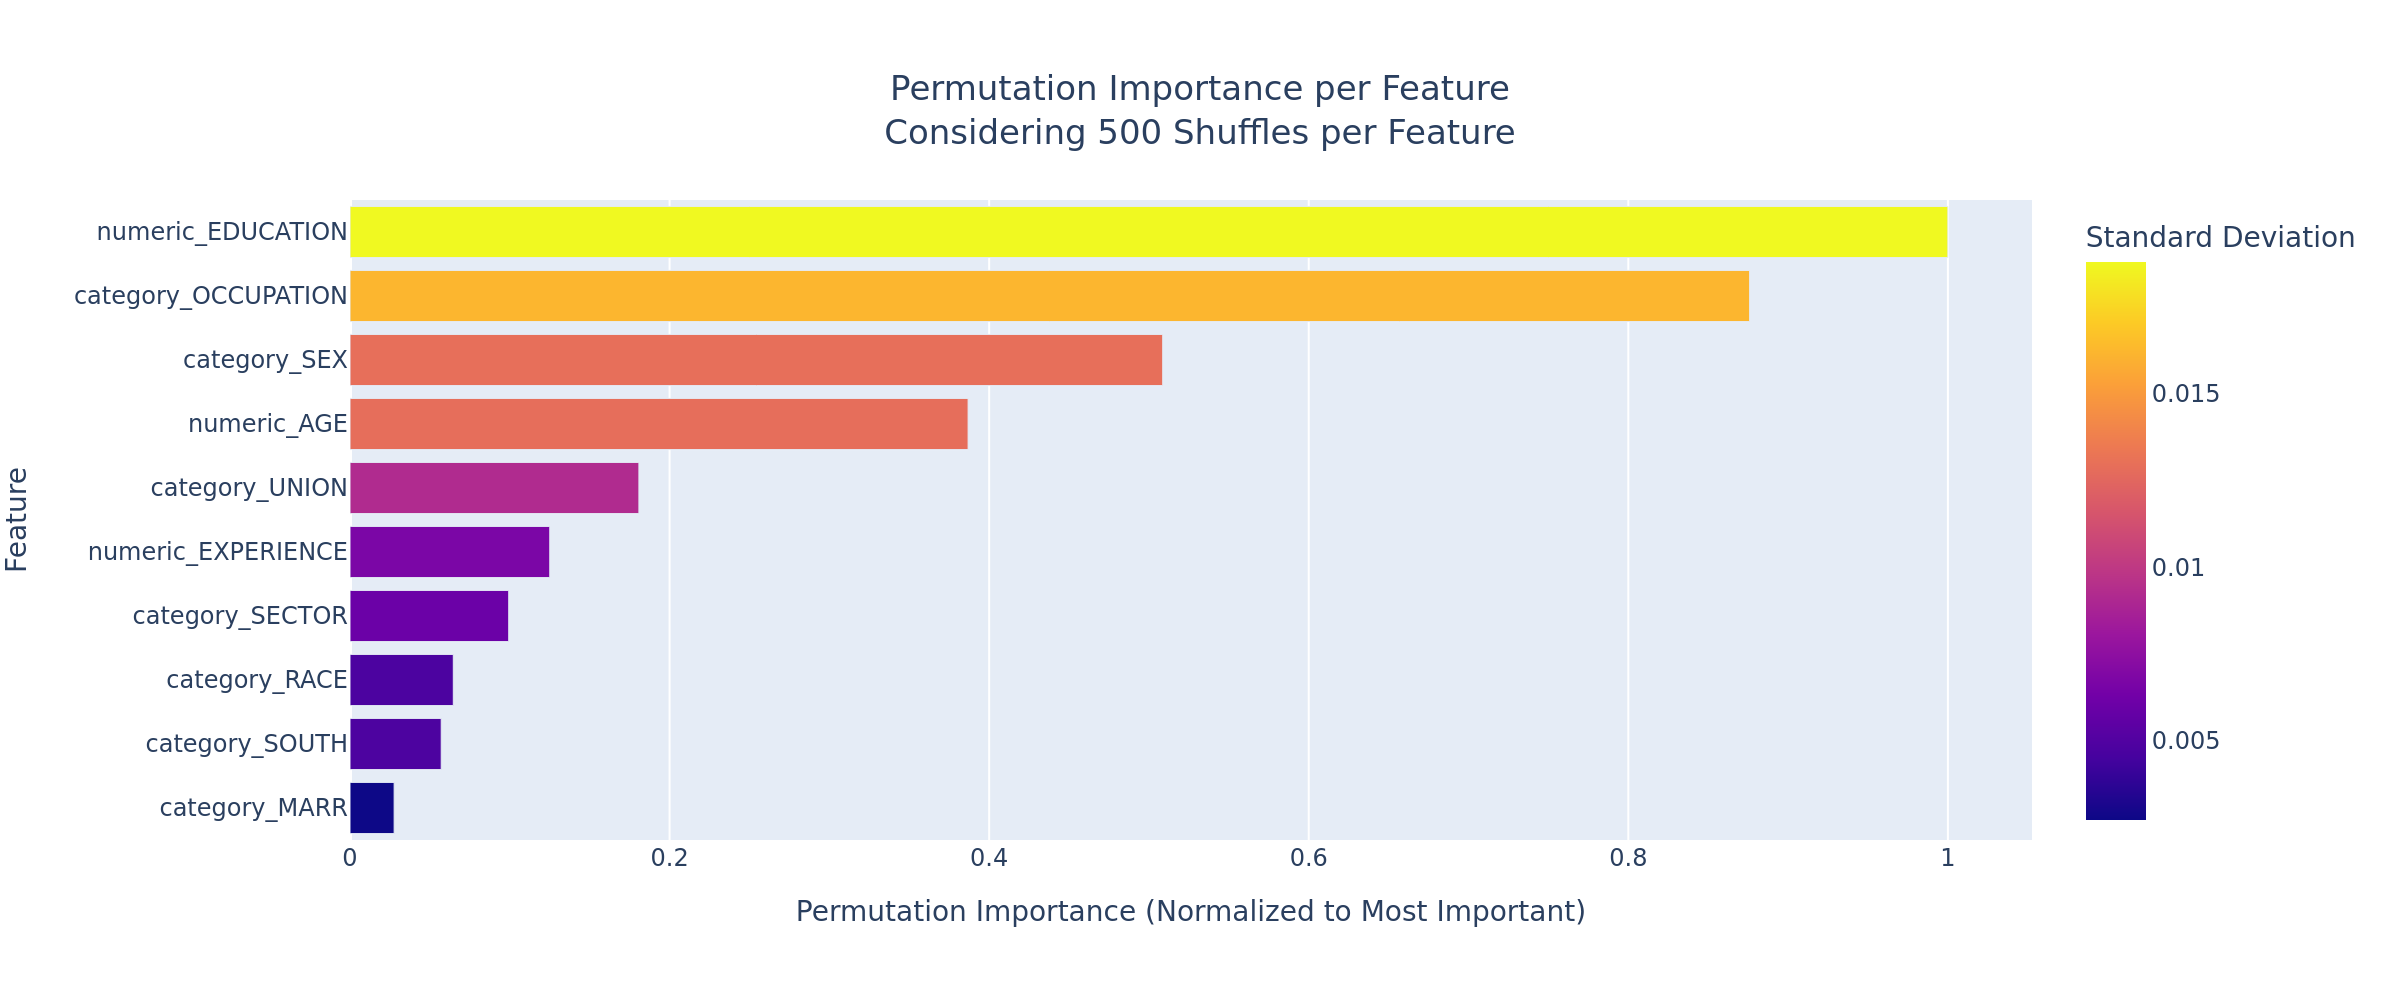

In [29]:
df_pi_reversed = df_pi[df_pi.columns[::-1]]

Image(
    px.bar(
        data_frame=df_pi_reversed.mean() / df_pi_reversed.mean()[-1],
        color=df_pi_reversed.std(),
        orientation="h",
        title="Permutation Importance per Feature<br>Considering %d Shuffles per Feature"
        % len(df_pi),
        labels={
            "value": "Permutation Importance (Normalized to Most Important)",
            "index": "Feature",
            "color": "Standard Deviation",
        },
    )
    .update_layout(title_x=0.5)
    .to_image(format="png", width=1200, scale=2)
)

Text(0, 0.5, 'Feature')

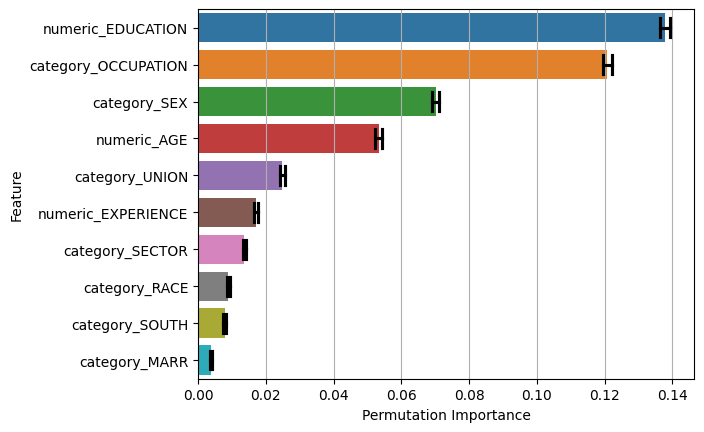

In [30]:
sns.barplot(
    df_pi,
    orient="h",
    err_kws={"color": "0.0"},
    capsize=0.5,
)

plt.xlabel("Permutation Importance")
plt.ylabel("Feature")